This notebook is for the purpose of developing the Object indicator.

## Imports

In [1]:
import os

import pandas as pd
import numpy as np
import spacy
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

# Set random seed for reproducibility
SEED=42
np.random.seed(SEED)

from utilities.funcoes import *
from utilities.schema import contracts_schema


# COMENTAR SE NÃO FOR NO SERVIDOR
from dotenv import load_dotenv
load_dotenv()

/home/cpinto/RISKGUARD/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

## Tentativa INDICADOR - 1011

### 1ª - Sample

Vou considerar Ajustes Diretos Regime Geral, Consultas Prévias e Concursos Públicos de 2023 - 158410

In [ ]:
# sample_contratos = pd.read_parquet(os.getenv('DATA_ROOT') + '/dados_2023.parquet')

In [2]:
sample_contratos = pl.read_parquet(
    os.getenv('DATA_ROOT') + '/dados_2023.parquet',
    columns=[
        'N.º Procedimento (ID BASE)', 'N.º Contrato', 'Tipo de procedimento',
        'Tipo(s) de contrato', 'Objeto_LIMPO', 'Objeto_LIMPO_2', 'Objeto'
    ])#.unique(subset=["N.º Contrato", "N.º Procedimento (ID BASE)"])

# atenção ao unique depois tenho de correr tudo outra vez para ter tudo direito

### 2º - Flagg de contratos que têm apenas pontuação e/ou número no objeto

In [3]:
sample_contratos = sample_contratos.with_columns(
    pl.when(pl.col('Objeto').str.contains("[A-Za-z]")).then(pl.lit(0)).otherwise(pl.lit(1)).alias('flag_1011')
)

### 3º -  Preprocessar as colunas de texto

In [7]:
# eliminar completamente solos e numeros
with open('pt-stopwords.txt', "r", encoding="utf-8") as f:
    stopwords = {line.strip().lower() for line in f if line.strip()}
stopwords=stopwords.union({'n.º'})

In [8]:
sample_contratos['Objeto_LIMPO']=sample_contratos['Objeto'].apply(lambda x: clean_text(x, lower = True, remove_numbers=False, pontuation=False) if pd.notna(x) else '')
sample_contratos['Objeto_TOKENS'] = sample_contratos['Objeto_LIMPO'].apply(lambda x: x.split() if pd.notna(x) else '')
sample_contratos['Objeto_LENGTH'] = sample_contratos['Objeto_TOKENS'].str.len()

In [9]:
sample_contratos['Objeto_LIMPO_2'] = sample_contratos['Objeto'].apply(lambda x: clean_text(x, lower = True, remove_numbers=True, pontuation=True, stopwords=stopwords) if pd.notna(x) else '')
sample_contratos['Tipo_LIMPO'] = sample_contratos['Tipo(s) de contrato'].apply(lambda x: clean_text(x, lower = True, remove_numbers=True, pontuation=True, stopwords=stopwords) if pd.notna(x) else '')

### 4º -  Sinalizar contratos que têm um objeto praticamente igual ao tipo de contrato

In [10]:
mask = sample_contratos['1011_flag']==0
sample_contratos_inclui_texto = deepcopy(sample_contratos[mask])
sample_contratos_so_numero = deepcopy(sample_contratos[~mask])

#### 4.1. Com o Jaccard Coefficient e Dice Similarity

In [ ]:
sample_contratos_inclui_texto["jaccard"] = sample_contratos_inclui_texto.apply(lambda row: jaccard_similarity(row["Objeto_LIMPO_2"], row["Tipo_LIMPO"]), axis=1)
sample_contratos_inclui_texto["dice"] = sample_contratos_inclui_texto.apply(lambda row: dice_similarity(row["Objeto_LIMPO_2"], row["Tipo_LIMPO"]), axis=1)

In [17]:
sample_contratos_inclui_texto[['jaccard', 'dice']].describe()

,jaccard,dice
count,158334.000000,158334.000000
mean,0.095408,0.157215
std,0.111913,0.167980
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.076923,0.142857
75%,0.166667,0.285714
max,1.000000,1.000000


In [24]:
sample_contratos_inclui_texto[sample_contratos_inclui_texto['jaccard']>0.65]['Objeto_LIMPO_2'].values[:10]

array(['aquisição serviços saúde', 'aquisição serviços viagens',
       'aquisição serviços viagens', 'aquisição serviços publicidade',
       'aquisição serviços formação', 'aquisição serviços dml',
       'aquisição serviços solicitadoria',
       'aquisição serviços publicidade', 'aquisição serviços publicidade',
       'aquisição serviços publicidade'], dtype=object)

In [19]:
sample_contratos_inclui_texto[sample_contratos_inclui_texto['dice']>0.8]['Objeto_LIMPO_2'].values[10:]

array(['aquisição serviços', 'aquisição bens móveis mobiliário',
       'aquisição serviços', 'aquisição serviços', 'aquisição serviços',
       'aquisição serviços', 'aquisição serviços'], dtype=object)

#### 4.2. Word2Vec

In [22]:
from gensim.models import Word2Vec                         

In [ ]:
sentences = sample_contratos_inclui_texto["Objeto_LIMPO_2"].apply(str.split).tolist()

model = Word2Vec(
    sentences,
    vector_size=100,
    window=5,
    min_count=3,
    workers=4,
    sg=1
)

In [ ]:
#Extract sentence embeddings from X_train_clean by averaging word embeddings per sentence ---
def average_embedding(text, model, dim):
    words = text.split()
    vectors = []
    for word in words:
        if word in model:
            vectors.append(model[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

In [ ]:
X_train_avgembeddings_from_scratch_50 = np.array([average_embedding(text, w2v_model_50.wv, dim=dim_50) for text in X_train_cleaned])
X_val_avgembeddings_from_scratch_50 = np.array([average_embedding(text, w2v_model_50.wv, dim=dim_50) for text in X_val_cleaned])

#### 4.3. Com o Serafim

In [4]:
embeddings_serafim_objeto = pl.read_parquet(os.getenv('DATA_ROOT') + '/serafim335_Objeto_LIMPO.parquet')
embeddings_serafim_tipo = pl.read_parquet(os.getenv('DATA_ROOT') + '/serafim335_Tipo(s) de contrato_LIMPO.parquet')

In [ ]:
# embeddings_serafim_objeto = pd.read_parquet(os.getenv('DATA_ROOT') + '/serafim335_Objeto_LIMPO.parquet')
# embeddings_serafim_tipo = pd.read_parquet(os.getenv('DATA_ROOT') + '/serafim335_Tipo(s) de contrato_LIMPO.parquet')

In [ ]:
# embeddings_serafim_objeto_inclui_texto = embeddings_serafim_objeto[mask.to_numpy()]
# embeddings_serafim_tipo_inclui_texto = embeddings_serafim_tipo[mask.to_numpy()]

In [5]:
def cosine_similarity(dfA, dfB, eps=1e-8):
    if dfA.shape != dfB.shape:
        raise ValueError(f"Shapes diferentes: {dfA.shape} vs {dfB.shape}")
    
    A = dfA.to_numpy()
    B = dfB.to_numpy()


    num  = (A * B).sum(axis=1)
    den  = np.linalg.norm(A, axis=1) * np.linalg.norm(B, axis=1) + eps
    cos  = np.full(A.shape[0], np.nan, dtype="float32")
    cos = num / den

    cos_dis = 1.0 - cos

    return cos_dis

In [6]:
cos = cosine_similarity(embeddings_serafim_objeto, embeddings_serafim_tipo)

In [7]:
sample_contratos = sample_contratos = sample_contratos.with_columns(
    pl.Series('dist_serafim_obj_tipo', cos),
)

In [8]:
k = 3.5

stats = sample_contratos.select(
    pl.col("dist_serafim_obj_tipo").mean().alias("mu"),
    pl.col("dist_serafim_obj_tipo").std().alias("sigma"),
).row(0)

mu, sigma = stats[0], stats[1]
upper = mu + k * sigma
lower = mu - k * sigma

In [9]:
sample_contratos = sample_contratos.with_columns(
    pl.when(
        (pl.col("flag_1011") == 0) &
        ((pl.col("dist_serafim_obj_tipo") > upper) | (pl.col("dist_serafim_obj_tipo") < lower))
    )
    .then(pl.lit(1))
    .otherwise(pl.col("flag_1011"))   # mantém o valor anterior
    .alias("flag_1011")
)

/home/cpinto/RISKGUARD/Contratos/scripts/1011_object/utilities/funcoes.py:568: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


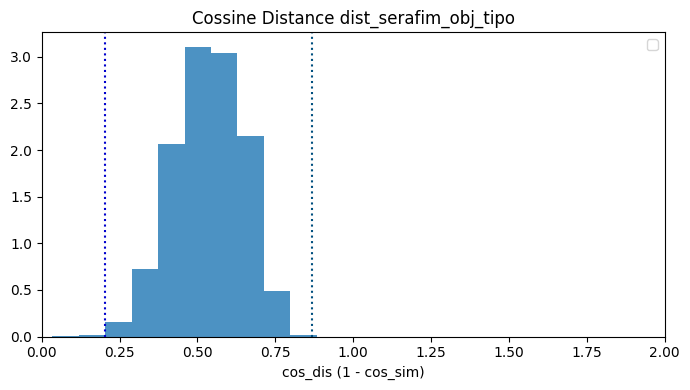

In [ ]:
# sample_contratos_inclui_texto['dist_serafim_obj_tipo'] = cosine_similarity(embeddings_serafim_objeto_inclui_texto, embeddings_serafim_tipo_inclui_texto)
# metric_col = 'dist_serafim_obj_tipo'
# distribution(df=sample_contratos_inclui_texto, metric_col_name = metric_col)

In [ ]:
# l_limit = sample_contratos_inclui_texto[metric_col].mean()-3.5*sample_contratos_inclui_texto[metric_col].std()
# u_limit = sample_contratos_inclui_texto[metric_col].mean()+3.5*sample_contratos_inclui_texto[metric_col].std()

In [ ]:
# sample_contratos_inclui_texto['1011_flag_serafim'] = sample_contratos_inclui_texto.apply(lambda row: flag_mal_definidos(row, metric_col, 
#                                                                                                                 lower_limit=l_limit, 
#                                                                                                                 upper_limit=u_limit), axis=1)
# sample_contratos_inclui_texto['1011_flag_serafim'].value_counts()

1011_flag_serafim
0    186507
1        47
Name: count, dtype: int64

In [ ]:
# sample_contratos_inclui_texto[sample_contratos_inclui_texto['1011_flag_serafim']==1][['Objeto_LIMPO', metric_col]]

,Objeto_LIMPO,dist_serafim_obj_tipo
1577924,aquisição de mobiliário,0.144823
1581646,aquisição de serviços de solicitadoria,0.128996
1649659,aquisição de serviços,0.034470
1671561,aquisição de mobiliário,0.147834
1671572,aquisição de mobiliário,0.147834
1794013,aquisição de serviços,0.058033
1827091,aquisição de serviços - aluguer de máquinas e ...,0.141594
1918785,aquisição de mobiliário,0.145768
1959458,aquisição de serviços,0.036517
1975434,aquisição de mobiliário,0.147611


In [ ]:
# mask_final = sample_contratos_inclui_texto['1011_flag']==0
# contratos_poss_amb = sample_contratos_inclui_texto[mask_final]
# contratos_mal_def = sample_contratos_inclui_texto[~mask_final]
# embeddings_serafim_objeto_poss_amb = embeddings_serafim_objeto_inclui_texto[mask_final.to_numpy()]

In [ ]:
# contratos_mal_def[['Objeto_LIMPO', metric_col]]

,Objeto_LIMPO,dist_serafim_obj_tipo


#### 4.4. Com o Labse

In [20]:
embeddings_labse_objeto = pd.read_parquet(os.getenv('DATA_ROOT') + '/labse_Objeto_LIMPO.parquet')
embeddings_labse_tipo = pd.read_parquet(os.getenv('DATA_ROOT') + '/labse_Tipo(s) de contrato_LIMPO.parquet')

In [21]:
embeddings_labse_objeto_inclui_texto = embeddings_labse_objeto[mask.to_numpy()]
embeddings_labse_tipo_inclui_texto = embeddings_labse_tipo[mask.to_numpy()]

/home/cpinto/RISKGUARD/Contratos/scripts/1011_object/utilities/funcoes.py:568: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


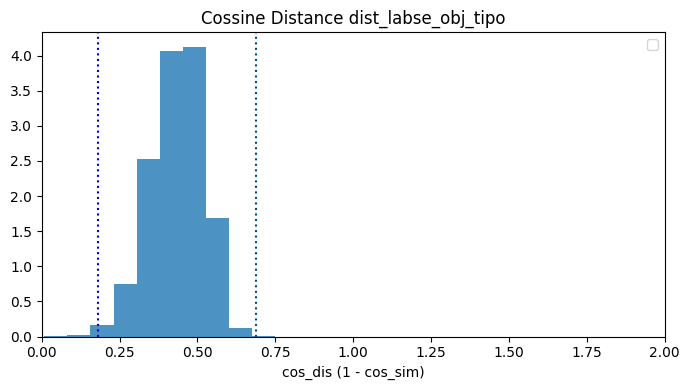

In [22]:
sample_contratos_inclui_texto['dist_labse_obj_tipo'] = cosine_similarity(embeddings_labse_objeto_inclui_texto, embeddings_labse_tipo_inclui_texto)
metric_col = 'dist_labse_obj_tipo'
distribution(df=sample_contratos_inclui_texto, metric_col_name = metric_col)

In [23]:
l_limit = sample_contratos_inclui_texto[metric_col].mean()-3.5*sample_contratos_inclui_texto[metric_col].std()
u_limit = sample_contratos_inclui_texto[metric_col].mean()+3.5*sample_contratos_inclui_texto[metric_col].std()

In [24]:
sample_contratos_inclui_texto['1011_flag_labse'] = sample_contratos_inclui_texto.apply(lambda row: flag_mal_definidos(row, metric_col, 
                                                                                                                lower_limit=l_limit, 
                                                                                                                upper_limit=u_limit), axis=1)
sample_contratos_inclui_texto['1011_flag_labse'].value_counts()

1011_flag_labse
0    186399
1       155
Name: count, dtype: int64

In [25]:
sample_contratos_inclui_texto[sample_contratos_inclui_texto['1011_flag_labse']==1][['Objeto_LIMPO', metric_col]].values[80:]

array([['aquisição de mobiliário', 0.07756191492080688],
       ['aquisição de bens', 0.09808933734893799],
       ['aquisição de mobiliário', 0.07951521873474121],
       ['aquisição de mobiliário', 0.08427298069000244],
       ['aquisição de serviços', 0.00894021987915039],
       ['aquisição de serviços de formação', 0.13392990827560425],
       ['aquisição de serviços de formação', 0.13392990827560425],
       ['aquisição de serviços de formação', 0.13486546277999878],
       ['aquisição de serviços', 0.010278284549713135],
       ['aquisição de serviços', 0.01111900806427002],
       ['aquisição de serviços de consultadoria', 0.13063979148864746],
       ['aquisição de serviços', 0.01111900806427002],
       ['aquisição de mobiliário', 0.07981204986572266],
       ['aquisição de serviços de transporte', 0.12972605228424072],
       ['aquisição de mobiliário', 0.07641541957855225],
       ['aquisição de mobiliário', 0.09126812219619751],
       ['aquisição de mobiliário', 0.0912681

In [26]:
embeddings_labse_objeto_poss_amb = embeddings_labse_objeto_inclui_texto[mask_final.to_numpy()]

In [27]:
# mask = sample_contratos_inclui_texto['1011_flag']==0
# contratos_poss_amb = sample_contratos_inclui_texto[mask]
# contratos_mal_def = sample_contratos_inclui_texto[~mask]
# embeddings_serafim_objeto_poss_amb = embeddings_serafim_objeto_inclui_texto[mask.to_numpy()]

In [28]:
# contratos_mal_def[['Objeto_LIMPO', metric_col]]

#### 4.4. Com o stjiris

In [42]:
embeddings_stjiris_objeto = pd.read_parquet(os.getenv('DATA_ROOT') + f'/paraphrase_Objeto_LIMPO.parquet')
embeddings_stjiris_tipo = pd.read_parquet(os.getenv('DATA_ROOT') + f'/paraphrase_Tipo(s) de contrato_LIMPO.parquet')

In [43]:
embeddings_stjiris_objeto_inclui_texto = embeddings_stjiris_objeto[mask.to_numpy()]
embeddings_stjiris_tipo_inclui_texto = embeddings_stjiris_tipo[mask.to_numpy()]

In [44]:
embeddings_stjiris_objeto

,Objeto_LIMPOdim0,Objeto_LIMPOdim1,Objeto_LIMPOdim2,Objeto_LIMPOdim3,Objeto_LIMPOdim4,Objeto_LIMPOdim5,Objeto_LIMPOdim6,Objeto_LIMPOdim7,Objeto_LIMPOdim8,Objeto_LIMPOdim9,...,Objeto_LIMPOdim758,Objeto_LIMPOdim759,Objeto_LIMPOdim760,Objeto_LIMPOdim761,Objeto_LIMPOdim762,Objeto_LIMPOdim763,Objeto_LIMPOdim764,Objeto_LIMPOdim765,Objeto_LIMPOdim766,Objeto_LIMPOdim767
0,-0.006392,-0.000398,-0.008428,-0.016465,0.008543,-0.014485,0.022778,0.003811,0.075987,0.001063,...,0.045466,0.016567,-0.033828,0.014268,-0.005526,0.012811,-0.023481,0.008546,-0.073398,-0.013826
1,0.002295,0.008375,-0.004157,-0.039313,0.011421,-0.007133,-0.004944,0.021198,-0.010056,0.011951,...,0.035200,-0.043477,-0.031037,-0.004143,-0.018196,-0.000177,0.007247,0.009111,-0.035192,0.000917
2,0.002295,0.008375,-0.004157,-0.039313,0.011421,-0.007133,-0.004944,0.021198,-0.010056,0.011951,...,0.035200,-0.043477,-0.031037,-0.004143,-0.018196,-0.000177,0.007247,0.009111,-0.035192,0.000917
3,-0.041286,0.056067,-0.005245,-0.042760,-0.003208,-0.007727,-0.047858,0.004119,0.066816,0.025407,...,0.034219,-0.033569,-0.001002,-0.020573,-0.002401,-0.024354,0.021448,0.027343,-0.027973,0.017885
4,0.002295,0.008375,-0.004157,-0.039313,0.011421,-0.007133,-0.004944,0.021198,-0.010056,0.011951,...,0.035200,-0.043477,-0.031037,-0.004143,-0.018196,-0.000177,0.007247,0.009111,-0.035192,0.000917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187393,-0.036196,-0.000118,-0.017852,0.012528,0.028161,0.016325,0.073148,-0.001396,0.018276,0.020521,...,-0.007438,0.014411,0.032932,0.024514,0.000809,0.019549,-0.006256,0.042739,-0.082670,-0.009912
187394,-0.010883,0.006698,-0.008454,-0.006773,-0.000091,-0.040468,0.023295,-0.019413,-0.045007,0.003156,...,0.018198,-0.050743,0.031038,0.027531,-0.005825,-0.016671,-0.034411,-0.011908,-0.013992,-0.053807
187395,-0.035788,-0.002206,-0.008635,0.013026,0.018117,-0.045743,-0.059783,-0.021285,0.002590,0.002463,...,0.016056,-0.045395,-0.071322,-0.003475,0.019529,-0.009584,0.001547,-0.011626,0.001510,-0.062883
187396,-0.025154,0.032166,-0.007666,0.059052,0.013771,-0.053628,0.020918,0.004374,0.012238,-0.003730,...,-0.005840,-0.062378,-0.035881,0.009195,0.008442,0.064784,-0.076151,0.027446,0.009802,-0.019493


/home/cpinto/RISKGUARD/Contratos/scripts/utilities/funcoes.py:494: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


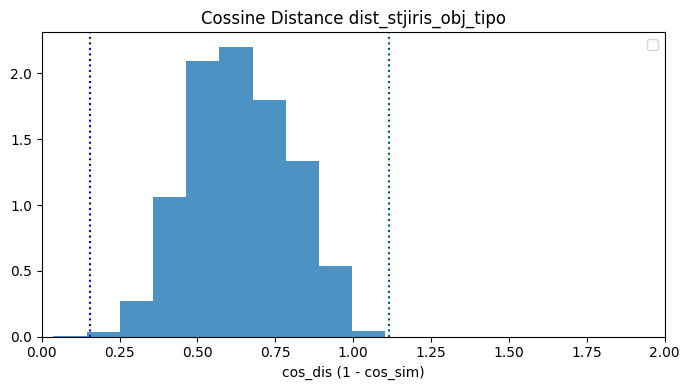

In [45]:
sample_contratos_inclui_texto['dist_stjiris_obj_tipo'] = cosine_similarity(embeddings_stjiris_objeto_inclui_texto, embeddings_stjiris_tipo_inclui_texto)
metric_col = 'dist_stjiris_obj_tipo'
distribution(df=sample_contratos_inclui_texto, metric_col_name = metric_col)

In [49]:
l_limit = sample_contratos_inclui_texto[metric_col].mean()-3.5*sample_contratos_inclui_texto[metric_col].std()
u_limit = sample_contratos_inclui_texto[metric_col].mean()+3.5*sample_contratos_inclui_texto[metric_col].std()

In [50]:
sample_contratos_inclui_texto['1011_flag_stjiris'] = sample_contratos_inclui_texto.apply(lambda row: flag_mal_definidos(row, metric_col, 
                                                                                                                lower_limit=l_limit, 
                                                                                                                upper_limit=u_limit), axis=1)
sample_contratos_inclui_texto['1011_flag_stjiris'].value_counts()

1011_flag_stjiris
0    186539
1        15
Name: count, dtype: int64

In [51]:
sample_contratos_inclui_texto[sample_contratos_inclui_texto['1011_flag_stjiris']==1][['Objeto_LIMPO', metric_col]]

,Objeto_LIMPO,dist_stjiris_obj_tipo
1649659,aquisição de serviços,0.037799
1794013,aquisição de serviços,0.063245
1959458,aquisição de serviços,0.039410
2058323,aquisições serviços,0.075285
2146220,aquisição de serviços,0.042508
2151448,aquisição de serviços,0.046605
2170630,aquisição de serviços,0.050096
2170634,aquisição de serviços,0.050096
2193796,aquisição de diversos serviços,0.068783
2212888,aquisição de serviços,0.043257


### 5º - Treinar modelo de classificação -> vou usar crossvalidation para validar os resultados que estou a obter

Resolver os problemas que estão para cima e colocar tudo num ficheiro py. Esta parte da cross validation correr num script à parte.


Corrigir a pipeline, colocar a correr a cross validation, fazer treino e teste, olama e ter um draft de um indicador. 

In [10]:
# from keras.models import Model
# from keras import layers
# from keras.metrics import AUC, F1Score, CategoricalAccuracy, TopKCategoricalAccuracy
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Masking, LSTM, Bidirectional, Dropout, Dense, GlobalMaxPooling1D, BatchNormalization
# from tensorflow.keras import regularizers
# from tensorflow.keras.optimizers import Adam~

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


from collections import Counter
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import ADASYN, BorderlineSMOTE, KMeansSMOTE

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
)

Embeddings que quero testar:

- Serafim
- Labse
- stjiris


Técnicas de smote que quero usar:

- Boderline
- ADASYN
- KMeans Smote


Rácio de oversampling que quero usar:

- Testar vários vetores/dicionários para as classes minoritárias



In [11]:
def my_strategy(y):
    import numpy as np
    from collections import Counter

    counts = Counter(y)
    max_n = max(counts.values())
    # e.g. bring every class to at least 60% of the majority
    return {cls: max(int(0.6 * max_n), n) for cls, n in counts.items()}

In [17]:
sample_contratos = sample_contratos.with_row_index("row_id")
embeddings_serafim_objeto = embeddings_serafim_objeto.with_row_index("row_id")

mask = pl.col("Tipo(s) de contrato")!="Outros"
contratos_sem_outros = sample_contratos.filter(mask)

DuplicateError: column with name 'row_id' has more than one occurrences

In [19]:
mask_df = (
    sample_contratos.filter(mask).select("row_id")
)
embeddings_serafim_objeto_sem_outros = embeddings_serafim_objeto.join(mask_df, on = "row_id", how="inner").drop("row_id")

In [28]:
y = contratos_sem_outros.select(pl.col('Tipo(s) de contrato')).to_pandas()
idx = np.arange(len(y))
X_serafim = embeddings_serafim_objeto_sem_outros.to_numpy()

In [ ]:
X_labse = embeddings_labse_objeto_sem_outros.to_numpy()

In [ ]:
mask = ((contratos_poss_amb['Tipo(s) de contrato']!='Outros'))
contratos_poss_amb_outros = contratos_poss_amb[~mask]
contratos_poss_amb_sem_outros = contratos_poss_amb[mask]

In [183]:
embeddings_serafim_objeto_poss_amb_sem_outros = embeddings_serafim_objeto_poss_amb[mask.to_numpy()]
embeddings_labse_objeto_poss_amb_sem_outros = embeddings_labse_objeto_poss_amb[mask.to_numpy()]

In [184]:
X_serafim = embeddings_serafim_objeto_poss_amb_sem_outros.to_numpy()
X_labse = embeddings_labse_objeto_poss_amb_sem_outros.to_numpy()

In [31]:
idx_train, idx_test = train_test_split(idx, 
                                       test_size=0.2,
                                        random_state=SEED,
                                        stratify=y,
                                        shuffle=True)

X_serafim_train_val = X_serafim[idx_train]
#X_labse_train_val = X_labse[idx_train]

X_serafim_test = X_serafim[idx_test]
#X_labse_test = X_labse[idx_test]

y_train_val = y.iloc[idx_train]
y_test = y.iloc[idx_test]

In [32]:
def make_min_ratio_strategy(y, min_ratio=0.1):
    counts = Counter(y)
    majority = max(counts.values())
    min_n = int(majority * min_ratio)
    return {cls: max(n, min_n) for cls, n in counts.items() if n < min_n}

#### Cross Validation

In [ ]:
embeddings = {
    "st_model_A": X_serafim_train_val,
    "st_model_B": X_labse_train_val,
}

oversamplers = {
    "adasyn": ADASYN,
    "borderlinesmote": BorderlineSMOTE,
}

models = {
    "Logistic Regression": LogisticRegression,
    "XGBoost": XGBClassifier,
    "Naive Bayes": GaussianNB
}

ratios = [0.05, 0.10] 

In [ ]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
splits = list(skf.split(np.zeros(len(y_train_val)), y_train_val))
y_train_val
len(X_serafim_train_val)
results = []  # metrics

for emb_name, X_emb in embeddings.items():
    for ratio in ratios:
        for ovs_name, Sampler in oversamplers.items():
            for fold_id, (train_idx, val_idx) in enumerate(splits):
                print(f"Running fold {fold_id}...")
                X_train, X_val = X_emb[train_idx], X_emb[val_idx]
                y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
                
                le = LabelEncoder()
                y_train_encoded = le.fit_transform(y_train)
                y_val_encoded = le.transform(y_val)

                # oversample on the training fold
                sampler = Sampler(
                    sampling_strategy=lambda y_train_encoded, rr=ratio: make_min_ratio_strategy(y_train_encoded, min_ratio=rr),
                    random_state=42,
                )
                X_train_res, y_train_res = sampler.fit_resample(X_train, y_train_encoded)

                # model 
                for model_name, model in models.items():
                    print(f"Fit model: {model_name} in the {ovs_name} strategy with the ratio {ratio}...")

                    if model_name == "Logistic Regression":
                        model = model(max_iter=1000)

                    else:
                        model = model()
                    
                    model.fit(X_train_res, y_train_res)

                    y_pred_train = model.predict(X_train)
                    y_pred_val = model.predict(X_val)

                    # compute metrics

                    accuracy_train = accuracy_score(y_train_encoded, y_pred_train)
                    accuracy_val = accuracy_score(y_val_encoded, y_pred_val)
                    precision_train = precision_score(y_train_encoded, y_pred_train, average='macro', zero_division=0)
                    precision_val = precision_score(y_val_encoded, y_pred_val, average='macro', zero_division=0)
                    recall_train = recall_score(y_train_encoded, y_pred_train, average='macro', zero_division=0)
                    recall_val = recall_score(y_val_encoded, y_pred_val, average='macro', zero_division=0)
                    f1_train = f1_score(y_train_encoded, y_pred_train, average='macro', zero_division=0)
                    f1_val = f1_score(y_val_encoded, y_pred_val, average='macro', zero_division=0)

                    print(f"f1 train: {f1_train}, f1_val: {f1_val}")

                    fold_result = {
                        "embedding": emb_name,
                        "ratio": ratio,
                        "oversampler": ovs_name,
                        "fold": fold_id,
                        "model": model_name,
                        "accuracy_train": accuracy_train,
                        "accuracy_val": accuracy_val,
                        "precision_train": precision_train,
                        "precision_val": precision_val,
                        "recall_train": recall_train,
                        "recall_val": recall_val,
                        "f1_train": f1_train,
                        "f1_vall": f1_val
                    }

                    results.append(fold_result)

Acontece que tenho um modelo que prevê concessão de serviços publicos como aquisição de serviços publicos.

Labels de concessão de serviços publicos, empreitadas de obras publicas e locação de bens móveis são muito mal previstos.

O problema são os falsos negativos -> vão para outras classes

#### Logistic regression adysn com 0.05 ratio e serafim -> parece ser o melhor

In [33]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_val)
y_test_encoded = le.transform(y_test)

/home/cpinto/RISKGUARD/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/cpinto/RISKGUARD/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
model = LogisticRegression(max_iter=1000, random_state = SEED)

sampler = ADASYN(
    sampling_strategy=lambda y_train_encoded, rr=0.05: make_min_ratio_strategy(y_train_encoded, min_ratio=rr),
    random_state=SEED
)

X_train_res, y_train_res = sampler.fit_resample(X_serafim_train_val, y_train_encoded)


model.fit(X_train_res, y_train_res)


y_pred_train = model.predict(X_serafim_train_val)
y_pred_test = model.predict(X_serafim_test)

In [35]:
print(classification_report(y_train_encoded, y_pred_train))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     78557
           1       0.93      0.91      0.92     59065
           2       0.13      0.80      0.22        60
           3       0.54      0.92      0.68       106
           4       0.87      0.85      0.86     10282
           5       0.55      0.50      0.52      1826

    accuracy                           0.93    149896
   macro avg       0.66      0.82      0.69    149896
weighted avg       0.93      0.93      0.93    149896



In [36]:
print(classification_report(y_test_encoded, y_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     19640
           1       0.93      0.91      0.92     14767
           2       0.01      0.07      0.02        15
           3       0.46      0.65      0.54        26
           4       0.87      0.85      0.86      2570
           5       0.54      0.50      0.52       457

    accuracy                           0.93     37475
   macro avg       0.63      0.66      0.64     37475
weighted avg       0.93      0.93      0.93     37475



Quero ver quais é que estão mal classificados pelo modelo, se são os mesmos mal classificados pelo LLM.

In [39]:
contracts_test = contratos_sem_outros.to_pandas().iloc[idx_test][["N.º Procedimento (ID BASE)", "N.º Contrato", "Objeto", "Tipo(s) de contrato"]]

In [40]:
contracts_test['pred_modelo'] = le.inverse_transform(y_pred_test)

In [ ]:
le.inverse_transform([0, 1, 2, 3, 4, 5])

# empreitadas de obras públicas; aquisição de serviços e aquisição de obras públicas o modelo está a prever muito bem

# vamos comparar isto com as previsões do LLM

array(['Aquisição de bens móveis', 'Aquisição de serviços',
       'Concessão de obras públicas', 'Concessão de serviços públicos',
       'Empreitadas de obras públicas', 'Locação de bens móveis'],
      dtype=object)

### 6º - Identificar ambiguidade com um LLM

Objetivos:
- Testar um modelo e treinar esse mesmo modelo -> logistic regression/random forest/KNN/CNN
- Fazer uma pipeline que teste vários modelos e vários prompts para fazer uma análise comparativa
- 2 modelos LLMs e 2 prompts para testar
- 1 zero shot classification(?)


Quero fazer testes para apresentar amanhã, e perguntar se posso correr tudo com todos os contratos até ao início do próximo ano - selecionar uma sample de contratos

In [41]:
from typing import Literal
from pydantic import BaseModel
from langchain_ollama import ChatOllama
from tqdm import tqdm
from langchain_core.prompts import ChatPromptTemplate

import time

In [ ]:
contratos_to_llm = deepcopy(contratos_sem_outros.to_pandas().iloc[idx_test])#[['N.º Contrato', 'Objeto_LIMPO']])

In [94]:
contratos_sem_outros[contratos_sem_outros['Tipo de procedimento']=='Concurso público'].shape

(29761, 10)

In [55]:
# só vou avaliar os contratos que têm como tipo de procedimento concursos públicos
contratos_to_llm = deepcopy(contratos_to_llm[contratos_to_llm['Tipo de procedimento']=='Concurso público'][["N.º Procedimento (ID BASE)", "N.º Contrato", "Objeto_LIMPO"]][:1000])

In [56]:
contratos_to_llm.rename(columns={"N.º Procedimento (ID BASE)": "Num", 'N.º Contrato': 'ID', 'Objeto_LIMPO': 'Objeto'}, inplace=True)
items = contratos_to_llm.to_dict('records')

In [57]:
Label = Literal["Aquisição de bens móveis", "Aquisição de serviços", "Locação de bens móveis", "Empreitadas de obras públicas", "Concessão de serviços públicos", "Concessão de obras públicas", "Outros"]

class ItemResult(BaseModel):
    num: str
    id: str
    label: Label

In [58]:
models = ['gemma3:27b', "mistral-small3.2:24b"]

In [59]:
prompt = ChatPromptTemplate.from_messages([
    ("system",
     "És um auditor de contratação pública e o teu objetivo é associar objetos contratuais à sua tipologia."
     "Devolve APENAS JSON válido correspondente ao schema pedido. "
     "Nunca incluas texto fora do JSON."),
    ("user",
     "Associa o objeto contratual seguinte a uma destas categorias {labels} e devolve "
     "JSON com 'num', 'id' e 'label'. \n\n"
     "num={Num}\nid={ID}\nobjeto={Objeto}")
])

labels_str = list(Label.__args__)
inputs = [{"Num": x["Num"], "ID": x["ID"], "Objeto": x["Objeto"], "labels": labels_str} for x in items]

B = 64
MAX_CONCURRENCY = 6

all_rows = []   # list of dicts: {"model":..., "num":..., "id":..., "label":...}
meta_rows = []  # model-level run metadata

for model in models:
    llm = ChatOllama(model=model, temperature=0)
    structured_llm = llm.with_structured_output(ItemResult, method="json_schema")
    chain = prompt | structured_llm

    t0 = time.time()
    errors = 0
    produced = 0

    for i in tqdm(range(0, len(inputs), B), desc=f"Model: {model}"):
        chunk = inputs[i:i+B]
        try:
            out = chain.batch(chunk, config={"max_concurrency": MAX_CONCURRENCY})
            produced += len(out)

            for inp, pred in zip(chunk, out):
                # pred is ItemResult (pydantic). Convert to dict safely.
                pred_d = pred.model_dump() if hasattr(pred, "model_dump") else dict(pred)

                all_rows.append({
                    "model": model,
                    "num": pred_d.get("num", inp["Num"]),
                    "id": pred_d.get("id", inp["ID"]),
                    "label": pred_d.get("label"),
                })
        except Exception:
            errors += 1
            # optional: fallback to per-item processing so you don't lose the whole batch
            for inp in chunk:
                try:
                    one = chain.invoke(inp)
                    pred_d = one.model_dump() if hasattr(one, "model_dump") else dict(one)
                    all_rows.append({
                        "model": model,
                        "num": pred_d.get("num", inp["Num"]),
                        "id": pred_d.get("id", inp["ID"]),
                        "label": pred_d.get("label"),
                    })
                    produced += 1
                except Exception:
                    all_rows.append({
                        "model": model,
                        "num": inp["Num"],
                        "id": inp["ID"],
                        "label": None,
                    })

    meta_rows.append({
        "model": model,
        "n_inputs": len(inputs),
        "n_produced": produced,
        "batch_errors": errors,
        "seconds": time.time() - t0,
    })

Model: mistral-small3.2:24b: 100%|██████████| 16/16 [21:54<00:00, 82.17s/it]


In [60]:
# agregar os resultados dos dois LLMs
resultados = pd.DataFrame(all_rows)
resultados_gema = deepcopy(resultados[resultados['model']=='gemma3:27b'].rename(columns={'label': 'label_gema'}))
resultados_mistral = deepcopy(resultados[resultados['model']=='mistral-small3.2:24b'].rename(columns={'label': 'label_mistral'}))
resultados_final = resultados_gema[['num', 'id', 'label_gema']].merge(resultados_mistral[['num', 'id', 'label_mistral']], on=['num', 'id'])

In [66]:
contratos_sem_outros = contratos_sem_outros.to_pandas()

In [68]:
contratos_sem_outros.loc[:,'N.º Contrato'] = contratos_sem_outros['N.º Contrato'].astype(str)
contratos_sem_outros.loc[:,'N.º Procedimento (ID BASE)']= contratos_sem_outros['N.º Procedimento (ID BASE)'].astype(str)


final = resultados_final.merge(contratos_sem_outros[['Objeto', 'Tipo(s) de contrato', 'N.º Contrato', 'N.º Procedimento (ID BASE)']], how = 'left',
                         left_on = ['id', 'num'], right_on = ['N.º Contrato', 'N.º Procedimento (ID BASE)'], suffixes=('_model', '_real'))
final.drop_duplicates(inplace=True)
final.drop(columns=['num', 'id'], inplace=True)

In [69]:
final['flag_gema'] = np.where(final['label_gema']!=final['Tipo(s) de contrato'], 1, 0)
final['flag_mistral'] = np.where(final['label_mistral']!=final['Tipo(s) de contrato'], 1, 0)

In [70]:
contracts_test['flag_lg'] = np.where(contracts_test['pred_modelo']!=contracts_test['Tipo(s) de contrato'], 1, 0)

In [71]:
contracts_test.loc[:,'N.º Contrato'] = contracts_test['N.º Contrato'].astype(str)
contracts_test.loc[:,'N.º Procedimento (ID BASE)']= contracts_test['N.º Procedimento (ID BASE)'].astype(str)

/tmp/ipykernel_3079846/3942948330.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['10291914' '10094612' '9866828' ... '10342293' '10321385' '10274642']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  contracts_test.loc[:,'N.º Contrato'] = contracts_test['N.º Contrato'].astype(str)
/tmp/ipykernel_3079846/3942948330.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['6734336' '6573098' '6298932' ... '6775503' '6758348' '6217436']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  contracts_test.loc[:,'N.º Procedimento (ID BASE)']= contracts_test['N.º Procedimento (ID BASE)'].astype(str)


In [72]:
comp = final.merge(contracts_test, how='left', 
                   on=['N.º Contrato', 'N.º Procedimento (ID BASE)'])

In [73]:
comp['sum'] = comp['flag_gema'] + comp['flag_mistral'] + comp['flag_lg']

In [74]:
comp.shape

(1005, 13)

In [79]:
comp[(comp['flag_gema']==1) | (comp['flag_mistral']==1) | (comp['flag_lg']==1)].shape

(123, 13)

In [80]:
comp[(comp['flag_lg']==1)].shape

(68, 13)

In [82]:
comp[(comp['flag_gema']==1)].shape

(82, 13)

In [88]:
comp[(comp['flag_gema']==1)].shape

(82, 13)

In [84]:
comp[(comp['flag_mistral']==1) & (comp['flag_lg']==1)].shape

(34, 13)

In [87]:
comp[(comp['flag_mistral']==1) & (comp['flag_gema']==1)].shape

(53, 13)

In [86]:
comp[(comp['flag_gema']==1) & (comp['flag_lg']==1) & (comp['flag_mistral']==1)].shape

(29, 13)

In [85]:
comp[(comp['flag_gema']==1) & (comp['flag_lg']==1)].shape

(35, 13)

In [77]:
comp[comp['sum']>1].shape

(64, 13)

In [91]:
comp[comp['sum']>1][['Objeto_x', 'Tipo(s) de contrato_x']].values

array([['CP_13_SRLF_UI_2023', 'Aquisição de bens móveis'],
       ['Concurso Público n.º2/2022', 'Aquisição de bens móveis'],
       ['Concurso Público n.º 2/SAS/2024', 'Aquisição de bens móveis'],
       ['75/CP/AT/2023 - Aquisição da renovação de assinatura do software Watson Assistant para suporte do atendimento não presencial da AT',
        'Aquisição de bens móveis'],
       ['Aquisição de energia elétrica em Média Tensão e Baixa Tensão Especial, para as instalações dos Municípios da CIMDOURO e afins - 2023',
        'Aquisição de bens móveis'],
       ['PA.130.2022.0001001 - Trabalhos de manutenção em 34 frações e 5 edifícios sitos nos concelhos de Lisboa, Amadora e Peniche',
        'Empreitadas de obras públicas'],
       ['CP 0709/23 - FORNECIMENTO E COLOCAÇÃO DE PAVIMENTO - GALERIA AÉREA',
        'Aquisição de serviços'],
       ['Concurso Público Internacional Para o Fornecimento de Gás Natural Veicular e Para a Prestação de Serviços de Exploração e Manutenção do Posto de 